**Imports**

In [90]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import gensim
import plotly.graph_objects as go
import tensorflow as tf
import gensim.downloader
import warnings
warnings.filterwarnings('ignore')

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load dataset**

In [120]:
# Load train data
train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding="latin1")

# Load test data
test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding="latin1")

# Merge train and test data
dataset = pd.concat([train, test])

**Pre-Processing**

In [121]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]', ' ', text)
    return substitute

# Apply functions on OriginalTweet of Train set
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : remove_url(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : remove_emoji(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : decontraction(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : char(x))
dataset['OriginalTweet'] = dataset['OriginalTweet'].apply(lambda x : x.lower())

**Split dataset**

In [122]:
X = dataset['OriginalTweet']
y = dataset['Sentiment']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=0)

num_label_train_index, num_label_train_values = np.unique(y_train, return_counts=True)
num_label_test_index, num_label_test_values = np.unique(y_test, return_counts=True)

**Plot class distribution**

In [13]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

**Plot distribution of the classes in train set and test set with five labels**

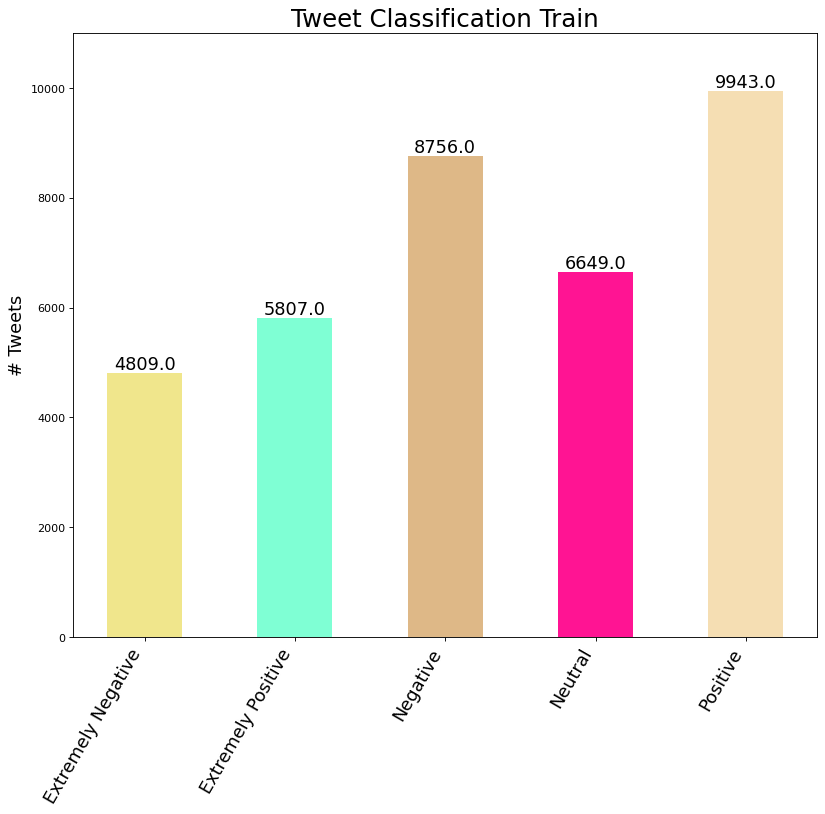

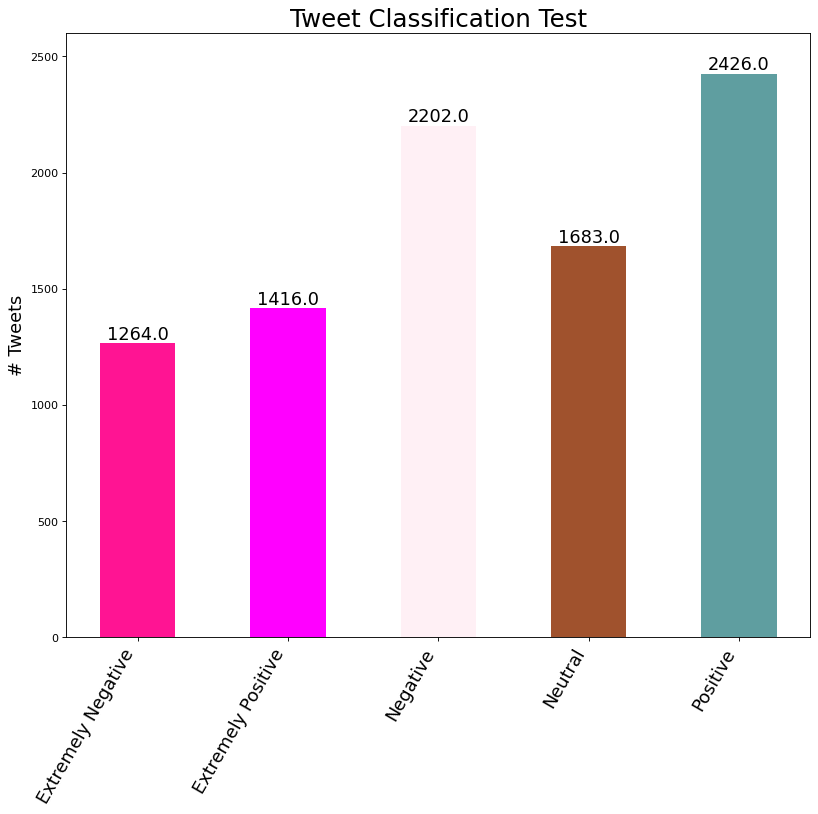

In [14]:
plot_class_dist(num_label_train_index, num_label_train_values, "Tweet Classification Train", 11000)
plot_class_dist(num_label_test_index, num_label_test_values, "Tweet Classification Test", 2600)

**Convert five labels to three labels**

In [123]:
def conv_sentiment(tweet_sentiment):
  if tweet_sentiment == "Extremely Positive":
    return "Positive"
  elif tweet_sentiment == "Extremely Negative":
    return "Negative"
  else:
    return tweet_sentiment

In [124]:
y_train = y_train.apply(lambda x: conv_sentiment(x))
y_test = y_test.apply(lambda x: conv_sentiment(x))

num_label_train_index, num_label_train_values = np.unique(y_train, return_counts=True)
num_label_test_index, num_label_test_values = np.unique(y_test, return_counts=True)

**Plot distribution of the classes in train set and test set with three labels**

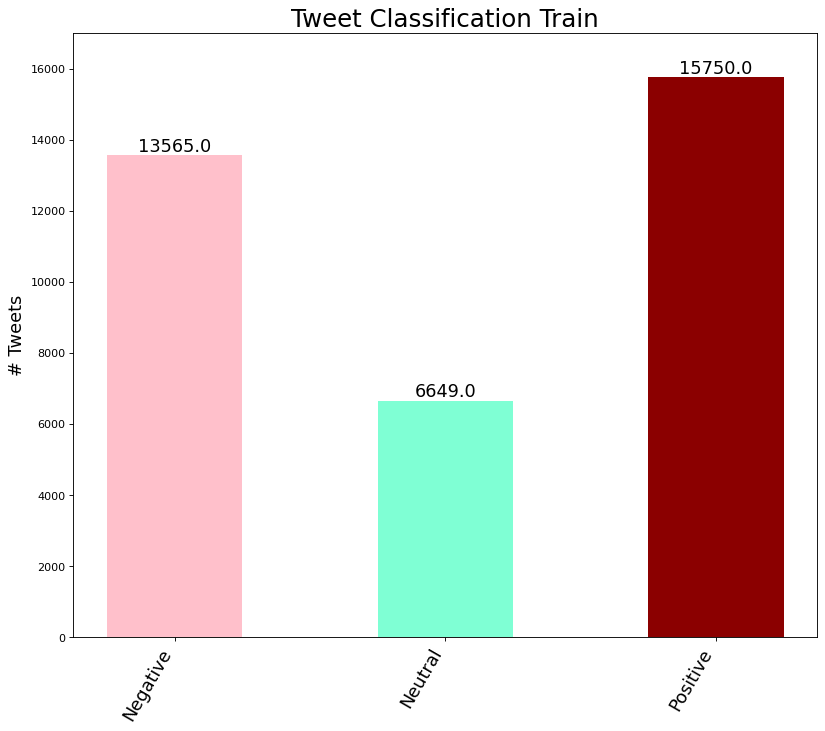

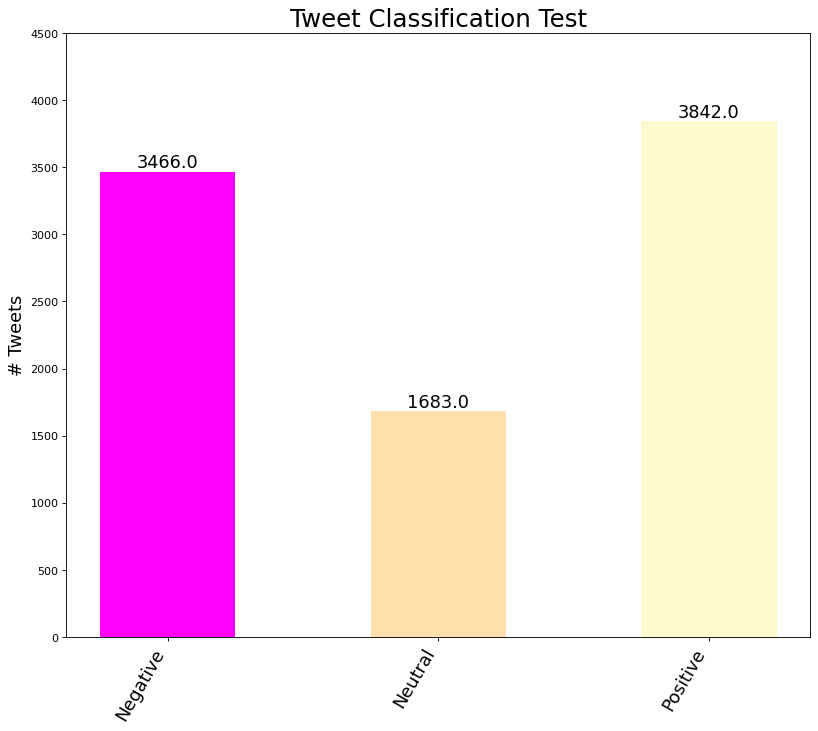

In [34]:
plot_class_dist(num_label_train_index, num_label_train_values, "Tweet Classification Train", 17000)
plot_class_dist(num_label_test_index, num_label_test_values, "Tweet Classification Test", 4500)

**Plot number of words in the tweets**

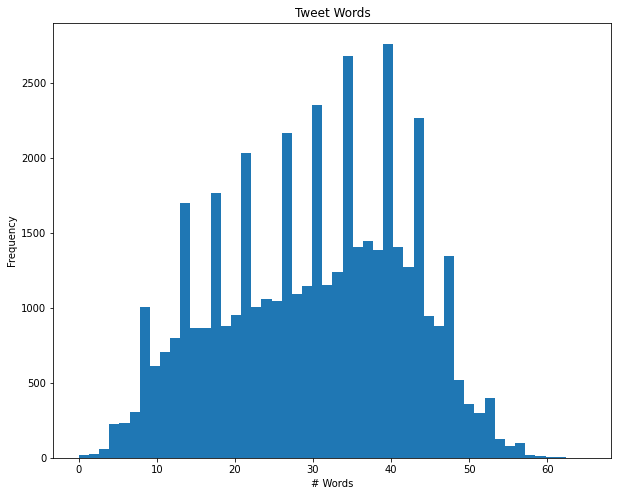

In [36]:
dataset['TotalWords'] = dataset['OriginalTweet'].str.lower().str.split().apply(len)

dataset['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Words").set_xlabel("# Words")
plt.show()

**Word cloud**

In [41]:
 # Split sentiment groups 
Positive = dataset[(dataset['Sentiment'] == "Extremely Positive") | (dataset['Sentiment'] == "Positive")].OriginalTweet
Neutral  = dataset[(dataset['Sentiment'] == "Extremely Negative") | (dataset['Sentiment'] == "Negative")].OriginalTweet
Negative = dataset[dataset['Sentiment'] == "Neutral"].OriginalTweet

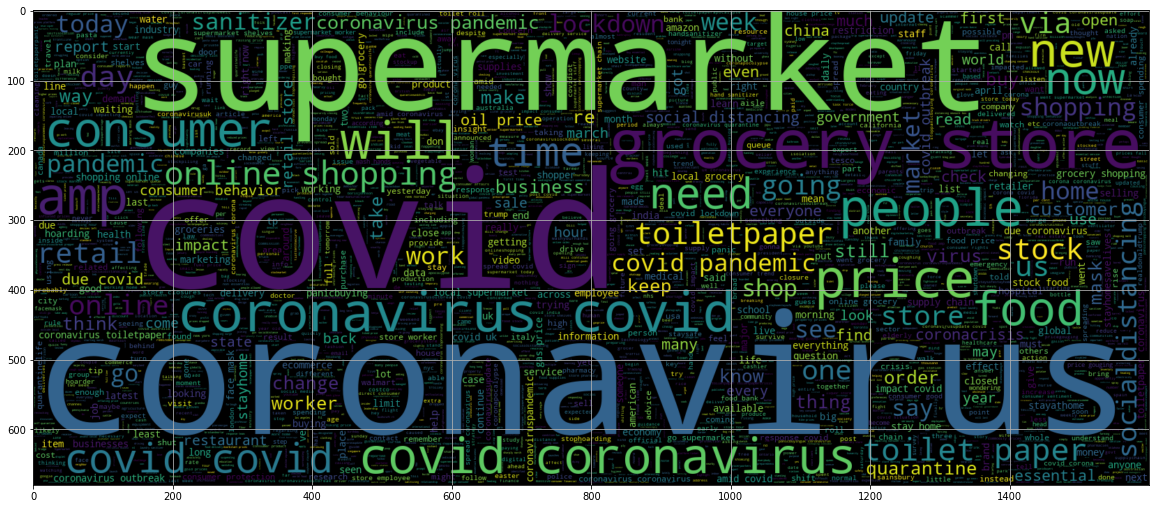

In [44]:
# WordCloud of Negative Tweets 
plt.figure(figsize = (20,20))
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Negative))
plt.imshow(wordcould, interpolation = 'bilinear')
plt.grid(None)

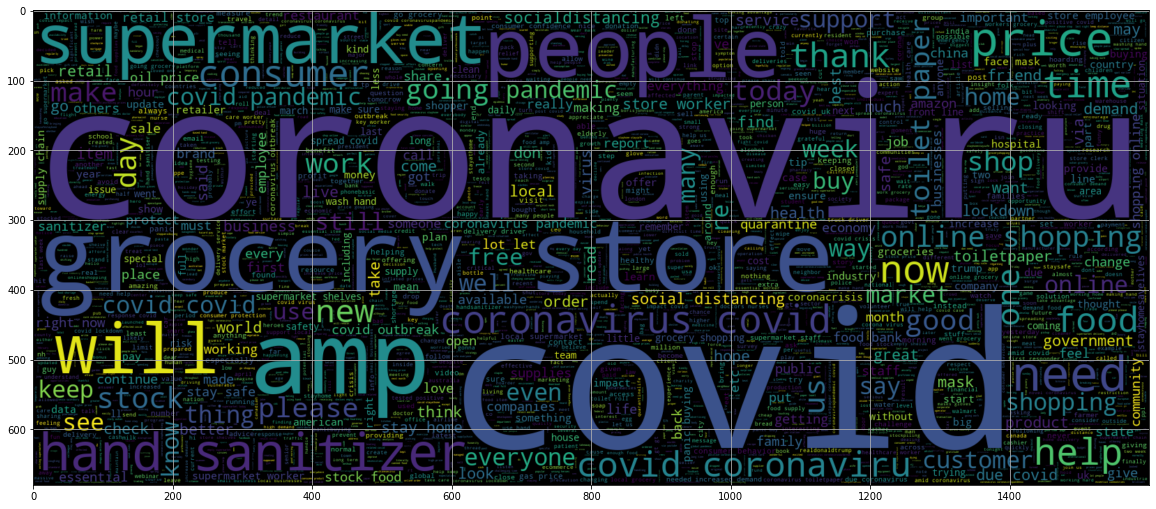

In [45]:
# WordCloud of Positive Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Positive))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

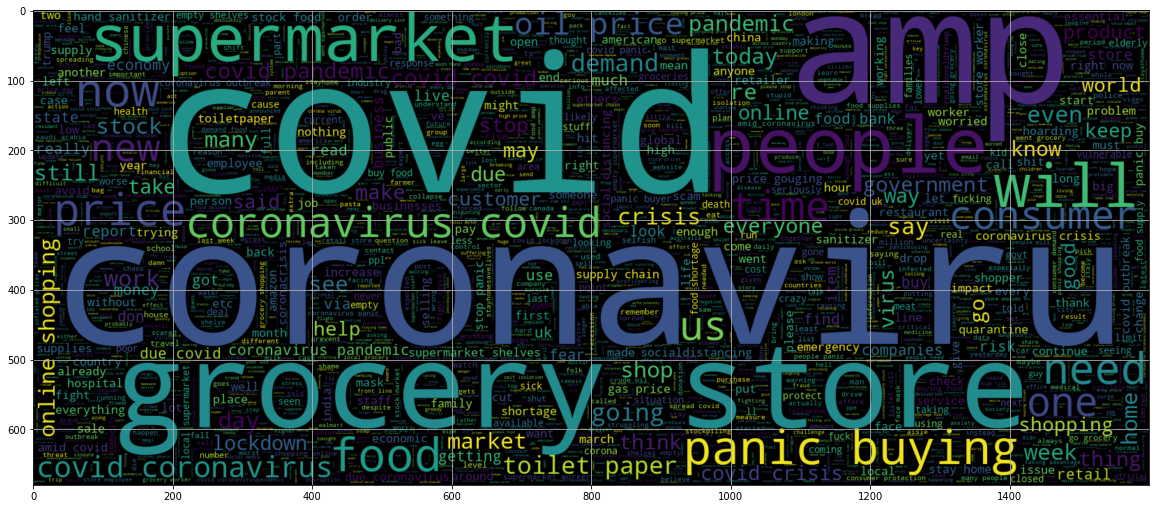

In [46]:
# WordCloud of Neutral Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Neutral))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

**Convert string labels to integer labels**

In [125]:
def conv_sentiment_to_int(tweet_sentiment):
  if tweet_sentiment == "Positive":
    return 0
  elif tweet_sentiment == "Negative":
    return 1
  else:
    return 2

In [126]:
y_train = y_train.apply(lambda x: conv_sentiment_to_int(x))
y_test = y_test.apply(lambda x: conv_sentiment_to_int(x))

**Word2Vec model**

Upload pre-trained model

In [ ]:
# Upload Gooogle News model
wv_from_bin = models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/DLA_dataset/GoogleNews-vectors-negative300.bin', binary=True)

# Length of words model
maxlen = 300

In [100]:
# Upload Twitter model
wv_from_bin = gensim.downloader.load('glove-twitter-100')

# Length of words model
maxlen = 100

[==================================================] 100.0% 387.1/387.1MB downloaded


****

Train model

In [73]:
wv_from_bin = models.Word2Vec(sentences=list(X_train))

# Length of words model
maxlen = 100

**Vectorized tweets**

In [74]:
def sent_vectorizer(sent, model):
  sent_vec = []
  numw = 0
  for w in sent:
    try:
      if numw == 0:
        sent_vec = model[w]
      else:
        sent_vec = np.add(sent_vec, model[w])
      numw+=1
    except:
      pass
  
  return np.asarray(sent_vec)/numw

In [101]:
x_train = []
for sentence in list(X_train):
    x_train.append(sent_vectorizer(sentence, wv_from_bin))

x_test = []
for sentence in list(X_test):
    x_test.append(sent_vectorizer(sentence, wv_from_bin))

In [102]:
x_train = pad_sequences(np.array(x_train), maxlen=maxlen)
x_test = pad_sequences(np.array(x_test), maxlen=maxlen)

**Baseline**

Multi-layer Perceptron

In [103]:
classifier = MLPClassifier()
y_pred = classifier.fit(x_train, y_train).predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


Multi-layer Perceptron with Cross Validation

In [104]:
clf = GridSearchCV(MLPClassifier(), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


Gaussian Naive Bayes

In [81]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 6565
0.26982538093649205


Gaussian Naive Bayes with Cross Validation

In [96]:
parameters = {}
clf = GridSearchCV(GaussianNB(), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 6565
0.26982538093649205


Logistic Regression

In [105]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


Logistic Regression with Cross Validation

In [106]:
parameters = {}
clf = GridSearchCV(LogisticRegression(random_state=0), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


SVM

In [83]:
clf = SVC(kernel='linear', max_iter=100, decision_function_shape='ovo')
y_pred = clf.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


SVM with Cross Validation

In [94]:
parameters = {}
clf = GridSearchCV(SVC(kernel='linear', max_iter=100, decision_function_shape='ovo'), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


Random Forest

In [85]:
clf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators=250)
y_pred = clf.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


Random Forest with Cross Validation

In [99]:
parameters = {}
clf = GridSearchCV(RandomForestClassifier(max_depth=50, random_state=0, n_estimators=250), parameters, cv=5).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))
print(clf.score(x_test, y_test))

Number of mislabeled points out of a total 8991 points : 4628
0.4852630408185964


**New Network**

In [127]:
# Split data into train , test
X_train , X_val , y_train , y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Convert y to categorical 
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)
y_val  = to_categorical(y_val, 3)

max_features = 20000
tokenizer = Tokenizer(num_words=max_features) # num_words=max_features, 
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

# convert tokenized texts into same padding size
#maxlen = 100
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val_final = pad_sequences(list_tokenized_val, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

41994


In [128]:
embeddings_index = {}
for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
  coefs = np.asarray(vector, dtype='float32')
  embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, maxlen))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

Found 1193514 word vectors.


In [129]:
model=Sequential()

#embedding layer
model.add(Embedding(len(tokenizer.word_index) + 1, maxlen, weights=[embedding_matrix], input_length=100, trainable=False))
#model.add(Embedding(max_features, embed_size))

#lstm layer
model.add(LSTM(60, return_sequences=True, dropout=0.2))
#model.add(LSTM(64, return_sequences=True, dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(3,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#Print summary of model
print(model.summary())

history = model.fit(X_train_final, y_train, epochs=2, validation_data=(X_val_final, y_val))

_,test_acc = model.evaluate(X_test_final, y_test)
print(test_acc)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          4199400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 60)           38640     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 60)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                3904      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 4,242,139
Trainable params: 42,739
Non-trainable params: 4,199,400
_________________________________________________________________
None
Epoch 1/2
900/900 [==============================] - 24s 24ms/step - loss: 0.7939 - acc: 0.6437 - va